In [9]:
import os
import io
import sys
import json
import pysolr
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from PIL import ImageFont
from pathlib import Path
from collections import Counter
from matplotlib.ticker import MaxNLocator

sys.path.append("../helpers/")
from impresso_id import *

solr_url = os.environ["SOLR_URL_DEV"]
solr = pysolr.Solr(solr_url + "/impresso_dev")

sns.set()

data_path = "data"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
with (open(os.path.join(data_path, "NLL_metadata.json"), "r")) as f:
    NLL_metadata = json.load(f)

In [6]:
df = pd.DataFrame().from_dict(NLL_metadata, orient="index")

df["year"] = df["pid"].apply(lambda x: get_year(x))
df["month"] = df["pid"].apply(lambda x: get_month(x))
df["day"] = df["pid"].apply(lambda x: get_day(x))
df["journal"] = df["pid"].apply(lambda x: get_journal(x))
df["edition"] = df["pid"].apply(lambda x: get_edition(x))
df["page"] = df["pid"].apply(lambda x: get_page(x))
df["meta_issue_id"] = df["pid"].apply(lambda x: get_meta_issue_id(x))

df["x"] = df["tb_coords"].apply(lambda x: np.min(x["x"]))
df["y"] = df["tb_coords"].apply(lambda x: np.min(x["y"]))
df["width"] = df["tb_coords"].apply(lambda x: np.max([x + w for x, w in zip(x['x'], x['width'])]) - np.min(x["x"]))
df["height"] = df["tb_coords"].apply(lambda x: np.max([x + h for x, h in zip(x['y'], x['height'])]) - np.min(x["y"]))
df["area"] = df.apply(lambda x: x["width"]*x["height"], axis=1)
df = df.drop("tb_coords", axis=1)

df.head()

,text_coords,pid,text,language,iiifURL,iiifFragmentURL,year,month,day,journal,edition,page,meta_issue_id,x,y,width,height,area
luxzeit1858-1858-03-10-a-i0018,"{'x': [259, 190, 259, 576, 605, 549, 574, 605,...",luxzeit1858-1858-03-10-a-p0001,Bezeichnung der Lebensmittel. Maße u. Gewichte...,fr,https://iiif.eluxemburgensia.lu/image/iiif/2/a...,[https://iiif.eluxemburgensia.lu/image/iiif/2/...,1858,3,10,luxzeit1858,a,1,luxzeit1858-1858-03-10-a,153,1320,1375,812,1116500
avenirgdl-1871-07-25-a-i0033,"{'x': [1422, 1535, 1424, 1422, 1535, 1423, 142...",avenirgdl-1871-07-25-a-p0004,Lnxemb. D Fentange. Bettemb A ThionTille SIeti...,en,https://iiif.eluxemburgensia.lu/image/iiif/2/a...,[https://iiif.eluxemburgensia.lu/image/iiif/2/...,1871,7,25,avenirgdl,a,4,avenirgdl-1871-07-25-a,1418,6225,610,546,333060
lunion-1867-01-10-a-i0017,"{'x': [2527, 2220, 2300, 2409, 2450, 2503, 258...",lunion-1867-01-10-a-p0001,"e Dép. Lux. 7"" œ 1"" 7""' Arr. Mort: 8""- 2""- 8"" ...",fr,https://iiif.eluxemburgensia.lu/image/iiif/2/a...,[https://iiif.eluxemburgensia.lu/image/iiif/2/...,1867,1,10,lunion,a,1,lunion-1867-01-10-a,2220,1021,431,224,96544
luxwort-1867-06-07-a-i0004,"{'x': [], 'y': [], 'width': [], 'height': [], ...",luxwort-1867-06-07-a-p0004,,,https://iiif.eluxemburgensia.lu/image/iiif/2/a...,[https://iiif.eluxemburgensia.lu/image/iiif/2/...,1867,6,7,luxwort,a,4,luxwort-1867-06-07-a,50,4922,3334,196,653464
lunion-1867-08-07-a-i0023,"{'x': [2181, 2273, 2364, 2403, 2182, 2264, 237...",lunion-1867-08-07-a-p0001,"I Heures dfi Coloi/ne.) Dép. Lux. 7 3s - 1""' 7...",fr,https://iiif.eluxemburgensia.lu/image/iiif/2/a...,[https://iiif.eluxemburgensia.lu/image/iiif/2/...,1867,8,7,lunion,a,1,lunion-1867-08-07-a,2179,1014,428,236,101008


We get all the segmented items on the given page and print them over it. We can print only tables, as well as OCR.

In [7]:
pid = "waeschfra-1880-06-26-a-p0002"
issue = df.loc[df['pid'] == pid, 'meta_issue_id'].iloc[0]
results = solr.search("*:*", **{
                      "fq": f"meta_issue_id_s:{issue}",
                      "wt": "json",
                      "rows": 1000})

results = [result for result in results if pid in result['page_id_ss']]

/Users/assa/opt/miniconda3/envs/pdm/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'iiif.eluxemburgensia.lu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


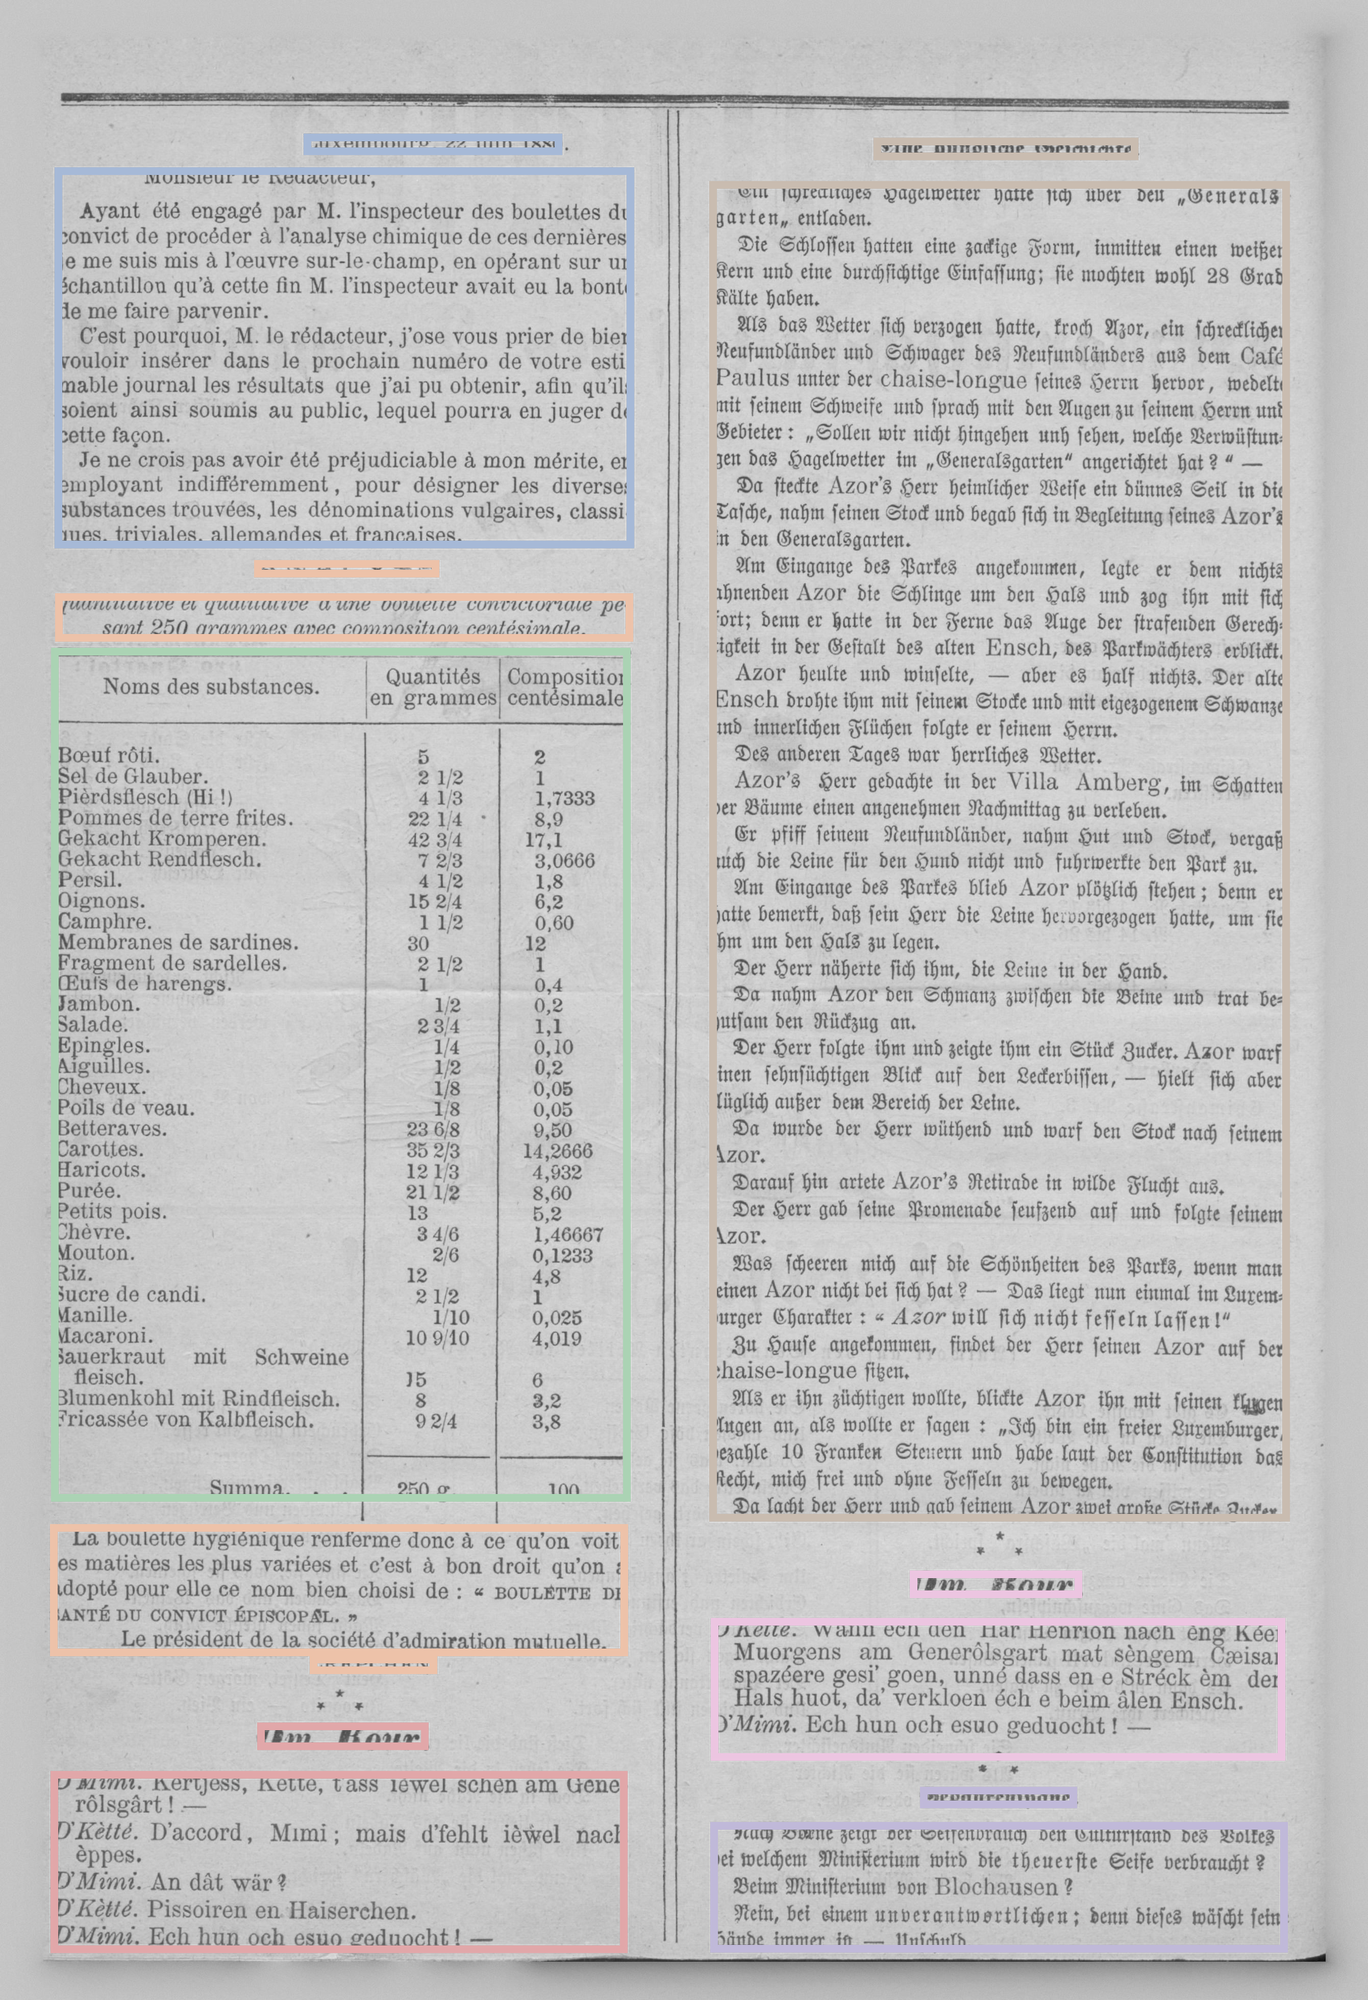

In [10]:
ocr = False
table = False

if ocr:
    # https://stackoverflow.com/questions/16373425/add-text-on-image-using-pil
    path_to_font = "/Library/Fonts/Arial Unicode.ttf"
    font = ImageFont.truetype(path_to_font, 35)

url = df.loc[df['pid'] == pid, "iiifURL"].iloc[0]
img_data = requests.get(url, verify=False).content
image = Image.open(io.BytesIO(img_data)).convert("RGBA")

colors = [(int(color[0]*255), int(color[1]*255), int(color[2]*255), 125) for color in sns.color_palette()]
draw = ImageDraw.Draw(image, "RGBA")
for i, result in enumerate(results):
    if not table or (table and result['item_type_s'] == 'tb'):
        for region in result['rc_plains']:
            if eval(region)['pid'] == pid:
                for coords in eval(region)['c']:
                        x, y, w, h = coords                  
                        draw.rectangle([x, y, x + w, y + h], outline=colors[i], width=15)
        
        if ocr:
            if 'content_txt_fr' in result.keys():
                text = result['content_txt_fr']
            elif 'content_txt_de' in result.keys():
                text = result['content_txt_de']
            else:
                print([k for k in result.keys() if k.startswith('content_txt')])

            for c in json.loads(result['pp_plain'])[0]['t']:
                x, y, w, h = c['c']
                draw.rectangle([x, y, x + w, y + h], fill=(255,255,255), width=15)
                word = text[c['s']:c['s']+c['l']]
                draw.text((x, y),word,(0,0,0), font=font)
        
image.thumbnail((2000,2000),Image.ANTIALIAS)

image